In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as io
import scipy.optimize as opt
from scipy import interpolate
from scipy.interpolate import UnivariateSpline


[  3.67763861e-02   6.00028439e+01  -4.47793211e+01]


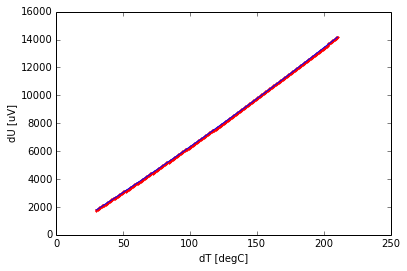

In [3]:
# data from type_E_sensor.pdf
filename = '/home/argo/masterarbeit/type_e_table_0_210_degC_raw.txt'

data = open(filename)

data_str = data.read()
data_str = data_str.replace('\n', ' ')
data = np.array(data_str.split(), dtype=float)[1:]
data = data[np.logical_not(np.mod(data, 10) == 0)]
data = np.concatenate(([0.], data))

seen = set()
U = np.array([x for x in data if not (x in seen or seen.add(x))])
U *= 1e3  # mV -> uV (microvolt)

T = range(len(U))

#k = U / T
#plt.plot(T[30:], k[30:], '.')
#plt.plot(T, U, '.')

deg = 2
coeffs_fit = np.polyfit(T[30:], U[30:], deg)
print coeffs_fit



fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(T[30:], U[30:], '.', color='red', linewidth=0.1)
ax.plot(T[30:], np.polyval(coeffs_fit, T[30:]))
ax.set_xlabel('dT [degC]')
ax.set_ylabel('dU [uV]')


[  5.09505329e-02   5.85548916e+01  -2.86468463e-01]


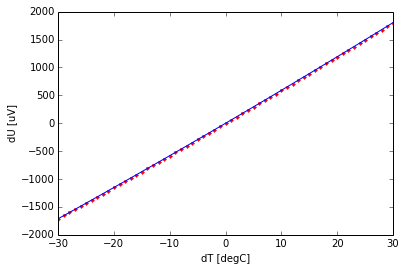

In [28]:
# data from type_E_sensor.pdf.
filename = '/home/argo/masterarbeit/type_e_table_pm30_degC_raw.txt'

dT = range(-30, 31)

data = np.loadtxt(filename)
data = np.concatenate(data[:,1:-1])
seen = set()
dU = np.array([x for x in data if not (x in seen or seen.add(x))])

dU *= 1e3  # mV -> uV (microvolt)


# fit
deg = 2
coeffs_fit = np.polyfit(dT, dU, deg)

print coeffs_fit

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dT, dU, '.', color='red')
ax.plot(dT, np.polyval(coeffs_fit, dT))
ax.set_xlabel('dT [degC]')
ax.set_ylabel('dU [uV]')